<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

In [35]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse as req

In [2]:
# вставьте сюда параметры подключения из юнита 1. Работа с базой данных из Python
import json

with open('data/connect.json', 'r') as f:
    config = json.load(f)

In [3]:
'''connection = psycopg2.connect(
    dbname=config['DBNAME'],
    user=config['USER'],
    host=config['HOST'],
    password=config['PASSWORD'],
    port=config['PORT']
)'''

#сделаем через SQLAlchemy, чтобы не было предупреждений
connection = f'''postgresql+psycopg2://{config['USER']}:{config['PASSWORD']}@{config['HOST']}:{config['PORT']}/{config['DBNAME']}'''


# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [4]:
# текст запроса
query_3_1 = f'''
    SELECT COUNT(*) AS num_vacancies
    FROM vacancies
'''

In [5]:
# результат запроса
num_vacancies = pd.read_sql_query(query_3_1, connection)
display(num_vacancies)

,num_vacancies
0,49197


2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [6]:
# текст запроса
query_3_2 = f'''
SELECT COUNT(*) AS num_employers
FROM employers
'''

In [7]:
# результат запроса
num_employers = pd.read_sql_query(query_3_2, connection)
display(num_employers)

,num_employers
0,23501


3. Посчитате с помощью запроса количество регионов (таблица areas).

In [8]:
# текст запроса
query_3_3 = f'''
SELECT COUNT(*) AS num_areas
FROM areas
'''

In [9]:
# результат запроса
num_areas = pd.read_sql_query(query_3_3, connection)
display(num_areas)

,num_areas
0,1362


4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [10]:
# текст запроса
query_3_4 = f'''
SELECT COUNT(*) AS num_industries
FROM industries
'''

In [11]:
# результат запроса
num_industries = pd.read_sql_query(query_3_4, connection)
display(num_industries)

,num_industries
0,294


***

### Выводы по предварительному анализу данных

Определено число записей во всех таблицах датасета. В среднем, на одну сферу деятельности приходится 160 вакансий, 17 работодателей на один регион. Но, естественно, это именно усредненные показатели, так как, например, в столичном регионе работодателей всегда намного больше, чем в провинции. В каждой сфере деятельности также могут быть разные потребности в работниках.

# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [12]:
# текст запроса
query_4_1 = f'''SELECT
    a.name AS area, -- выводим наименования регионов
    COUNT(v.name) AS cnt_vacancies_on_areas -- выводим общее количество вакансий
FROM
    vacancies AS v
-- объединяем таблицу вакансий с таблицей регионов
JOIN areas AS a ON v.area_id = a.id
GROUP BY area -- группируем по регионам
ORDER BY count(v.name) DESC -- сортируем количество вакансий по убыванию
LIMIT 5 -- ограничиваем вывод'''

,area,cnt_vacancies_on_areas
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892


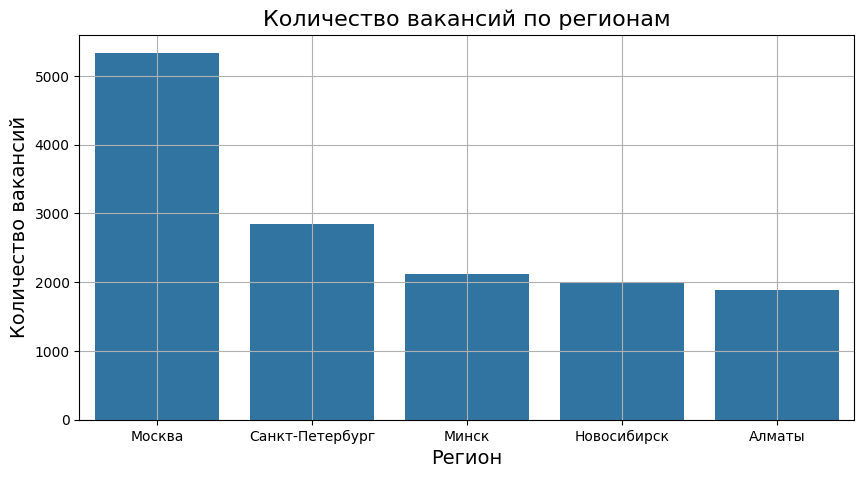

In [13]:
# результат запроса
cnt_vacancies_on_areas = pd.read_sql_query(query_4_1, connection)
display(cnt_vacancies_on_areas)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
barplot = sns.barplot(
    data=cnt_vacancies_on_areas,
    x='area',
    y='cnt_vacancies_on_areas',
    orient='v'
)
barplot.set_title('Количество вакансий по регионам', fontsize=16);
barplot.set_xlabel('Регион', fontsize=14);
barplot.set_ylabel('Количество вакансий', fontsize=14);
barplot.grid()

2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [14]:
# текст запроса
query_4_2 = f'''SELECT
    COUNT(name) AS cnt_vacancies_with_salary -- выводим количество вакансий
FROM vacancies
-- фильтруем вакансии, где указана мин или макс ЗП
WHERE salary_from IS NOT NULL OR salary_to IS NOT NULL'''

In [15]:
# результат запроса
cnt_vacancies_with_salary = pd.read_sql_query(query_4_2, connection)
display(cnt_vacancies_with_salary)

,cnt_vacancies_with_salary
0,24073


3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [16]:
# текст запроса
query_4_3 =  f'''SELECT
    ROUND(AVG(salary_from), 0) AS salary_from_avg,
    ROUND(AVG(salary_to), 0) AS salary_to_avg
FROM vacancies'''

In [17]:
# результат запроса
avg_salary = pd.read_sql_query(query_4_3, connection)
display(avg_salary)

,salary_from_avg,salary_to_avg
0,71065.0,110537.0


4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [18]:
# текст запроса
query_4_4 = f'''SELECT 
    COUNT(name) AS count_vacancies_on_type, -- количество вакансий
    schedule, -- тип рабочего графика
    employment -- тип трудоустройства
FROM vacancies
-- группируем по типу рабочего графика
-- и типу трудоустройства
GROUP BY schedule, employment
ORDER BY count_vacancies_on_type DESC -- сортируем вакансии по убыванию'''

,count_vacancies_on_type,schedule,employment
0,35367,Полный день,Полная занятость
1,7802,Удаленная работа,Полная занятость
2,1593,Гибкий график,Полная занятость
3,1312,Удаленная работа,Частичная занятость
4,940,Сменный график,Полная занятость


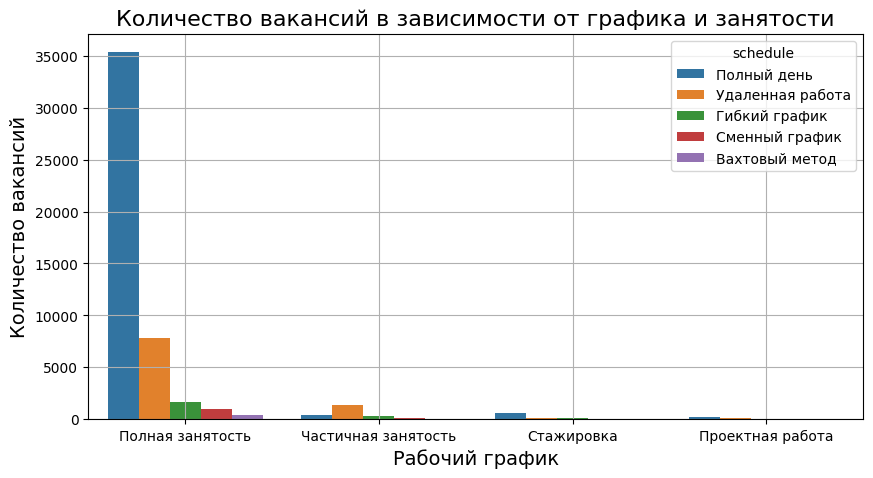

In [19]:
# результат запроса
count_vacancies_on_type = pd.read_sql_query(query_4_4, connection)
display(count_vacancies_on_type.head())

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
barplot = sns.barplot(
    data=count_vacancies_on_type,
    x='employment',
    hue='schedule',
    y='count_vacancies_on_type',
    orient='v'
)
barplot.set_title('Количество вакансий в зависимости от графика и занятости', fontsize=16);
barplot.set_xlabel('Рабочий график', fontsize=14);
barplot.set_ylabel('Количество вакансий', fontsize=14);
barplot.grid()

5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [20]:
# текст запроса
query_4_5 = f'''SELECT
    experience, -- требуемый опыт работы
    COUNT(name) AS vacancies -- количество вакансий
FROM vacancies
GROUP BY experience -- группируем по опыту работы
ORDER BY count(name) ASC -- сортируем вакансии по возрастанию''' 

,experience,vacancies
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


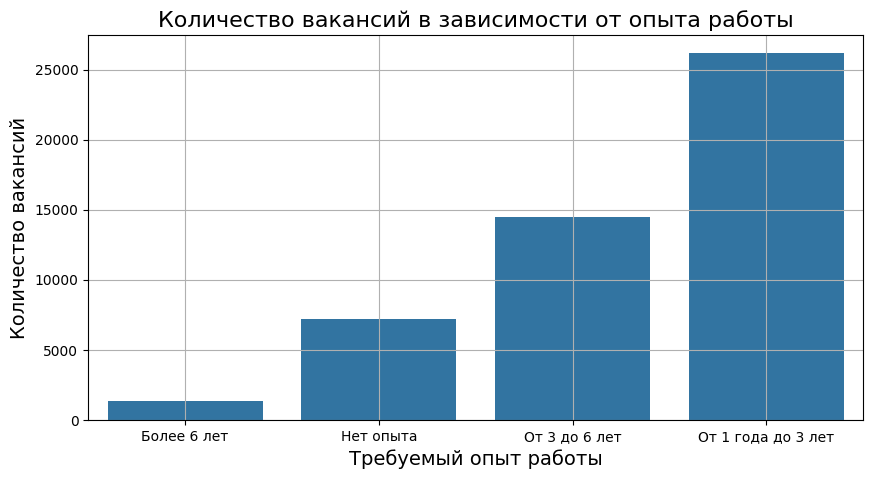

In [21]:
# результат запроса
experience = pd.read_sql_query(query_4_5, connection)
display(experience)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
barplot = sns.barplot(
    data=experience,
    x='experience',
    y='vacancies',
    orient='v'
)
barplot.set_title('Количество вакансий в зависимости от опыта работы', fontsize=16);
barplot.set_xlabel('Требуемый опыт работы', fontsize=14);
barplot.set_ylabel('Количество вакансий', fontsize=14);
barplot.grid()

***

### Выводы по детальному анализу вакансий

1. Как и ожидалось, наибольшее число вакансий относится к столичным регионам (больше всего в Москве, на втором месте - Санкт-Петербург).
2. Средние значения для нижней и верхней границы зарплатной вилки соответствуют средним показателям зарплаты по России на текущий момент времени.
3. Большинство работодателей ищут сотрудников на полный рабочий день - полную занятость. Удаленная работа нпбирает популярность, но таких вакансий все еще значительно меньше.
4. Требуемый опыт для большинства вакансий составляет от 1 года до 3 лет. Это говорит о том, что, во-первых, большинство вакансий относится к рядовым должностям, которые допускают больший уровень текучки кадров, чем высокие должности. Во-вторых, большинство работодателей все еще не готовы доверять сотрудникам без опыта.

# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [22]:
# текст запроса
query_5_1 = f'''SELECT
    emp.name AS employers, --наименование работодателя
    COUNT(v.name) AS count_vacancies --количество вакансий
FROM employers AS emp
-- объединяем с таблицей вакансий
-- где id работодателя равно id работодателя в таблице вакансий
JOIN vacancies AS v ON v.employer_id = emp.id
GROUP BY employers -- группируем по работодателям
ORDER BY count_vacancies DESC -- сортируем по вакансиям в порядке убывания
LIMIT 5 -- ограничиваем вывод 5 строками'''

,employers,count_vacancies
0,Яндекс,1933
1,Ростелеком,491
2,Тинькофф,444
3,СБЕР,428
4,Газпром нефть,331


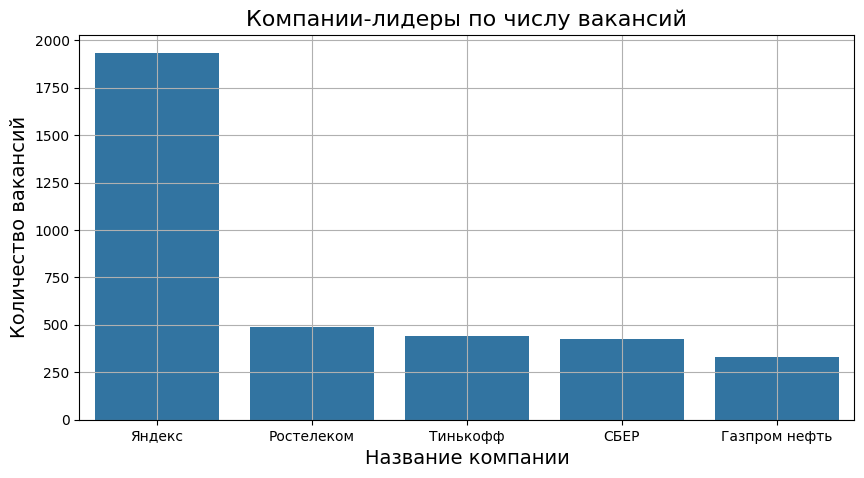

In [23]:
# результат запроса
count_vacancies_of_employers = pd.read_sql_query(query_5_1, connection)
display(count_vacancies_of_employers)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
barplot = sns.barplot(
    data=count_vacancies_of_employers,
    x='employers',
    y='count_vacancies',
    orient='v'
)
barplot.set_title('Компании-лидеры по числу вакансий', fontsize=16);
barplot.set_xlabel('Название компании', fontsize=14);
barplot.set_ylabel('Количество вакансий', fontsize=14);
barplot.grid()

2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [24]:
# текст запроса
query_5_2 = f''' SELECT
    ar.name AS area, --наименование региона
    COUNT(emp.name) AS count_employers, --количество работодателей
    COUNT(v.name) AS count_vacancies --количество вакансий
FROM areas AS ar
/*
присоединяем к таблице регионов таблицу работодателей,
где id региона == id региону работодателя. LEFT JOIN, т к нужно
оставить все регионы
*/
LEFT JOIN employers AS emp ON ar.id = emp.area
/*
присоединяем таблицу вакансий,
где id региона == id региону вакансии
*/
LEFT JOIN vacancies AS v ON ar.id = v.area_id
GROUP BY ar.name -- группируем по регионам
HAVING COUNT(v.name) = 0 -- фильтруем по количеству вакансий
ORDER BY count_employers DESC -- сортируем по количеству работодателей
LIMIT 1 --ограничиваем вывод 1 регионом'''

In [25]:
# результат запроса
count_employers_of_area_without_vacancies = pd.read_sql_query(query_5_2, connection)
display(count_employers_of_area_without_vacancies)

,area,count_employers,count_vacancies
0,Россия,410,0


3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [26]:
# текст запроса
query_5_3 = f'''SELECT
    emp.name AS employer_name, --работодатели
    COUNT(DISTINCT v.area_id) AS count_areas --количество регионов
FROM employers AS emp
/*
присоединяем таблицу вакансий
где id работодателя равен id вакансии работодателя
*/
JOIN vacancies AS v ON v.employer_id=emp.id
GROUP BY emp.name -- группируем по работодателю
ORDER BY count_areas DESC -- сортируем по количеству вакансий в порядке убывания'''

In [27]:
# результат запроса
count_area_of_employers = pd.read_sql_query(query_5_3, connection)
display(count_area_of_employers)

,employer_name,count_areas
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71
...,...,...
14761,UniSol,1
14762,UNISTORY LLC,1
14763,UNIT6,1
14764,United Distribution,1


4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [28]:
# текст запроса
query_5_4 = f'''SELECT 
    COUNT(emp.name) AS count_emp_without_ind  --количество работодателей
FROM employers AS emp
/*
присоединяем к таблице работодателей таблицу со сферами деятельности работодателей
где id работодателя равен id сфере деятельности работодателя, берем все записи из первой таблицы
*/
LEFT JOIN employers_industries AS ei ON emp.id = ei.employer_id
WHERE ei.industry_id is NULL -- фильтруем по наличию пустых значений в столбце со сферой деятельности'''

In [29]:
# результат запроса
count_emp_without_ind = pd.read_sql_query(query_5_4, connection)
display(count_emp_without_ind)

,count_emp_without_ind
0,8419


5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [30]:
# текст запроса
query_5_5 = f'''SELECT
    emp.name AS employer_name -- наименование работодателя
FROM employers AS emp
/*
присоединяем к таблице работодателей таблицу со сферами деятельности работодателей 
где id работодателя равен id сфере деятельности работодателя, используем LEFT JOIN
для сохранения всех записей первой таблицы
*/
LEFT JOIN employers_industries AS ei ON emp.id = ei.employer_id
GROUP BY emp.id  -- группируем по id работодателя
HAVING COUNT(ei.industry_id) = 4 -- фильтруем по количеству сфер деятельности
ORDER BY emp.name -- сортируем по наименованию работодателя
OFFSET 2 LIMIT 1 -- выводим третью строку'''

In [31]:
# результат запроса
employer_name_with_four_ind = pd.read_sql_query(query_5_5, connection)
display(employer_name_with_four_ind)

,employer_name
0,2ГИС


6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [32]:
# текст запроса
query_5_6 = f'''SELECT
    COUNT(emp.name) AS count_employers --количество работодателей
FROM employers AS emp
/*
присоединяем к таблице работодателей таблицу со сферами деятельности работодателей 
где id работодателя равен id сфере деятельности работодателя,
используем LEFT JOIN для сохранения всех записей первой таблицы
*/
LEFT JOIN employers_industries AS ei ON emp.id = ei.employer_id
/*
присоединяем таблицу с вариантами деятельности работодателей
где id сферы деятельности работодателя равен id варианта сферы деятельности,
используем LEFT JOIN для сохранения всех записей первой таблицы
*/
LEFT JOIN industries AS ind ON ei.industry_id = ind.id 
WHERE ind.name = 'Разработка программного обеспечения' -- фильтруем по названию сферы деятельности'''

In [33]:
# результат запроса
employers_of_it = pd.read_sql_query(query_5_6, connection)
display(employers_of_it)

,count_employers
0,3553


7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [ ]:
# код для получения списка городов-милионников
# разбирает URL-адрес на составляющие
path_common = req.urlparse('https://ru.wikipedia.org/wiki/Города-миллионеры_России#Список_городов-миллионеров')
# собирает URL-адрес обратно с использованием метода экранирования 
url = path_common.scheme + '://' + req.quote(path_common.netloc) +  req.quote(path_common.path) + '#'+ req.quote(path_common.fragment)
display(url)
# выделяем города
cities = pd.read_html(url)[0]
display(cities)
# преобразуем переменную с городами в кортеж, чтобы были круглые скобки в выводе, а не квадратные
mil_cities = tuple(cities['Город'])
# выводим кортеж
display(mil_cities)

'https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8#%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D0%BE%D0%B2'

,№,Город,"Население, тыс. чел. (на 1 января 2025)[2]","Население, тыс. чел. (перепись-2021)[3]",Прирост относительно переписи-2010,"Население, тыс. чел. (перепись-2010)[4]"
0,1,Москва,13 150,13 010,"13,1 %",11 504
1,2,Санкт-Петербург,5 598,5 602,"14,8 %",4 880
2,3,Новосибирск,1 634,1 634,"10,9 %",1 474
3,4,Екатеринбург,1 545,1 544,"14,4 %",1 350
4,5,Казань,1 319,1 309,"14,4 %",1 144
5,6,Красноярск,1 205,1 188,"21,6 %",977
6,7,Нижний Новгород,1 205,1 226,"−2,0 %",1 251
7,8,Челябинск,1 177,1 190,"5,3 %",1 130
8,9,Уфа,1 163,1 145,"7,8 %",1 062
9,10,Самара,1 159,1 173,"0,3 %",1 169


('Москва',
 'Санкт-Петербург',
 'Новосибирск',
 'Екатеринбург',
 'Казань',
 'Красноярск',
 'Нижний Новгород',
 'Челябинск',
 'Уфа',
 'Самара',
 'Ростов-на-Дону',
 'Краснодар',
 'Омск',
 'Воронеж',
 'Пермь',
 'Волгоград')

In [ ]:
# текст запроса
query_5_7=f'''WITH city AS (
    SELECT   
        ar.name AS area, --регион
        count(v.name) AS count_vacancies --кол-во вакансий
    FROM employers AS emp
    /*
    присоединяем таблицу вакансий
    где id вакансии работодателя равен id работодателя 
    */   
    JOIN vacancies AS v ON v.employer_id = emp.id
    /*
    присоединяем таблицу регионов
    где id региона равен id региона вакансии
    */  
    JOIN areas AS ar ON ar.id = v.area_id
    WHERE emp.name = 'Яндекс' -- фильтруем по наименованию работодателя
    GROUP BY ar.name -- группируем по названию региона
    /*
    фильтруем по названию региона
    где регионы это регионы из ранее созданного кортежа
    */ 
    HAVING ar.name IN {mil_cities}   
    ORDER BY COUNT(v.name) DESC -- сортируем по количеству вакансий в порядке убывания 
)
-- основной запрос
    SELECT  
        city.area, --регион
        city.count_vacancies --кол-во ваканси
    -- обращаемся к вспомогательному запросу
    FROM city
    UNION ALL
    /*
    присоединяем строку total
    и сумму  количества вакансий в регионах
    */
    SELECT
        'total',
        SUM(city.count_vacancies)
    FROM city'''

,area,count_vacancies
0,Москва,54.0
1,Санкт-Петербург,42.0
2,Екатеринбург,39.0
3,Нижний Новгород,36.0
4,Новосибирск,35.0
5,Воронеж,32.0
6,Краснодар,30.0
7,Самара,26.0
8,Уфа,26.0
9,Казань,25.0


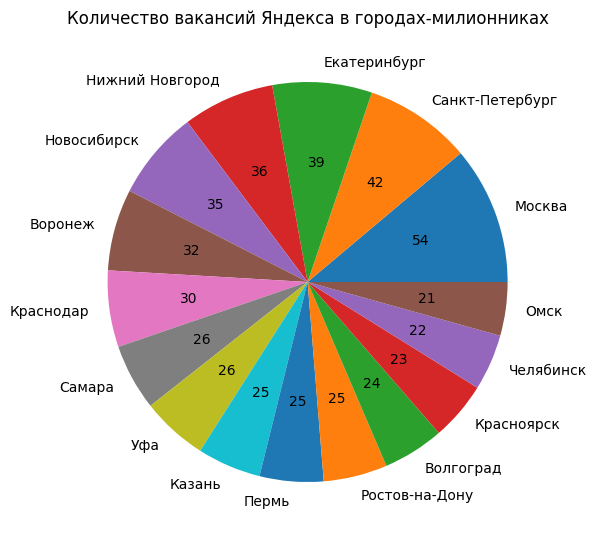

In [69]:
# результат запроса
regions_of_yandex = pd.read_sql_query(query_5_7, connection)
display(regions_of_yandex)

regions_of_yandex_df = regions_of_yandex.copy().drop(16)
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    regions_of_yandex_df['count_vacancies'],
    labels=regions_of_yandex_df['area'],
    autopct=lambda x: '{:.0f}'.format(x*regions_of_yandex_df['count_vacancies'].sum()/100),
);
axes.set_title('Количество вакансий Яндекса в городах-милионниках');

***

In [ ]:
# выводы по анализу работодателей

# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [ ]:
# текст запроса

In [ ]:
# результат запроса

2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [ ]:
# текст запроса

In [ ]:
# результат запроса

3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [ ]:
# текст запроса

In [ ]:
# результат запроса

4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [ ]:
# текст запроса

In [ ]:
# результат запроса

5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [ ]:
# текст запроса

In [ ]:
# результат запроса

6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [ ]:
# текст запроса

In [ ]:
# результат запроса

***

In [ ]:
# выводы по предметному анализу

# Общий вывод по проекту

In [ ]:
# подведем итог исследования, обобщите выводы
# здесь можно (это будет плюсом) провести дополнительные исследования данных, сделать прогнозы, продумать варианты продолжения исследования